In [49]:
import torch
import torch.nn as nn
import re
import requests

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

url = "https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt"
response = requests.get(url)
text = response.text


text = re.sub(r'\n\s*\n', ' <PARA> ', text)  # Replace paragraph breaks with <PARA>
text = "\n".join(line + " " for line in text.splitlines())  # Add space at the end of each line
text = re.sub('[^a-zA-Z0-9 \.<>]', '', text)  # Keep only alphanumeric, space, period, and tokens
text = text.lower().strip()

words = re.findall(r'\b\w+\b|[.]|<PARA>', text)
vocab = sorted(set(words + ["<>"]))  # Add <> to the vocabulary
stoi = {s: i for i, s in enumerate(vocab)}  # Map each token to a unique index
itos = {i: s for s, i in stoi.items()}      # Reverse map from index to token

cpu


In [53]:
activation_function= "Relu"
activation_func= nn.ReLU()
block_size=10
embedding_dim=32

In [55]:
class NextWordModel(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation_func):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.activation = activation_func
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x))
        x = self.lin2(x)
        return x

# Initialize the model with the same architecture
vocab_size = len(stoi)
model = NextWordModel(block_size, vocab_size, embedding_dim, 1024,activation_func)  # Ensure these match the original model

model_filename = "/kaggle/input/123456/next_word_model_2_32_10_relu_500.pth"
model.load_state_dict(torch.load(model_filename, map_location='cpu'))


/tmp/ipykernel_30/4006633045.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filename, map_location='cpu'))


<All keys matched successfully>

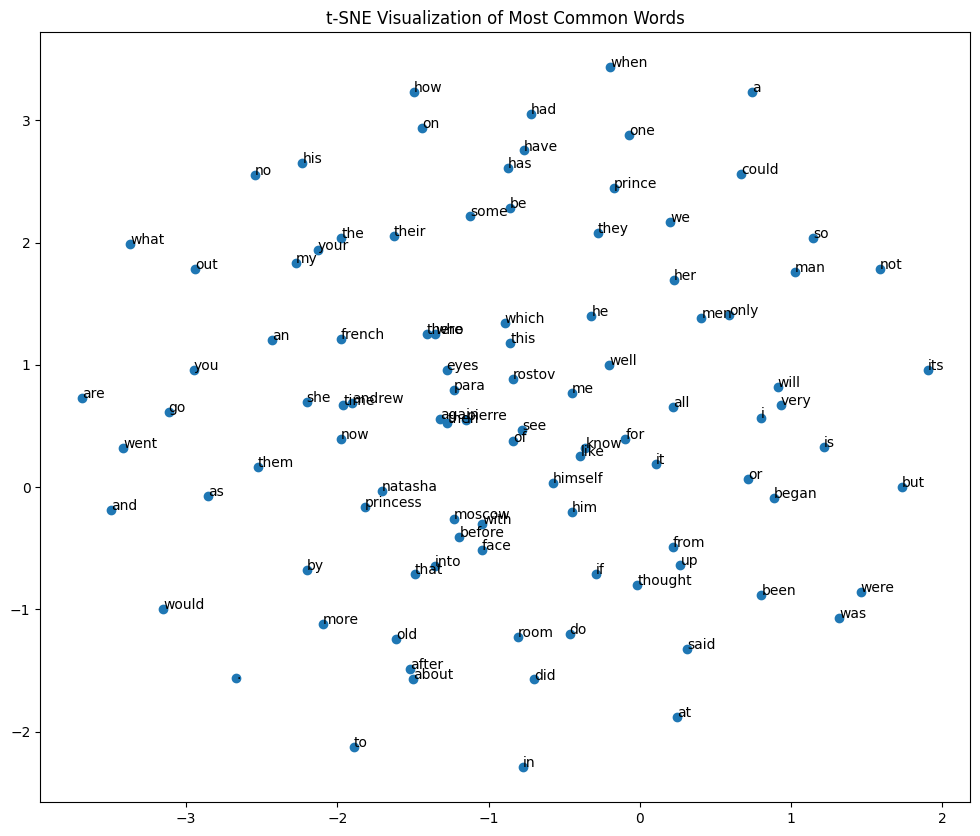

In [56]:
# Count the most common words
word_counts = Counter(words)
most_common_words = [word for word, _ in word_counts.most_common(100)]  # Get the 100 most frequent words

# Extract embeddings for the most common words
selected_indices = [stoi[word] for word in most_common_words if word in stoi]
selected_embeddings = model.emb.weight[selected_indices].detach().cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Annotate points with selected words
for i, word in enumerate(most_common_words):
    if word in stoi:
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], word)

plt.title('t-SNE Visualization of Most Common Words')
plt.show()


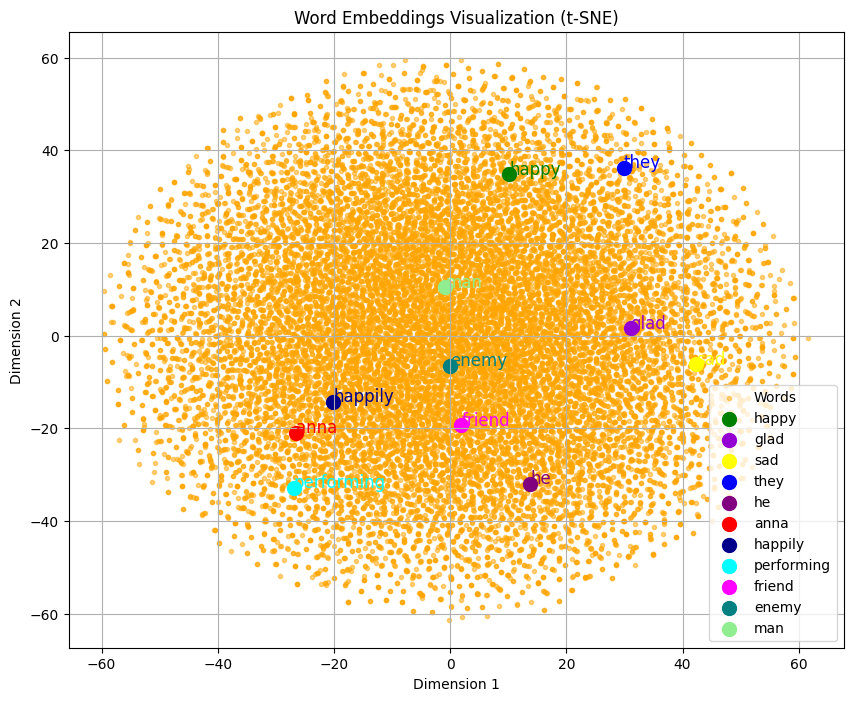

In [57]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Get word embeddings from the model
word_indices = torch.arange(vocab_size)
embeddings = model.emb(word_indices).detach().numpy()

# Apply t-SNE if embedding dimension is greater than 2
if embeddings.shape[1] > 2:
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
else:
    embeddings_2d = embeddings  # Use embeddings directly if already 2-dimensional

# Define words to highlight
words_to_highlight = ['happy', 'glad', 'sad', 'they', 'he', 'anna', 'happily', 'performing','friend','enemy','man']

# Get the indices of these words
indices_to_highlight = [stoi.get(word, None) for word in words_to_highlight]

# Plotting all embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, color='orange', marker='.', label='Words') 

# Highlight specific words (if they exist in the vocabulary)
colors = ['green', 'darkviolet', 'yellow', 'blue', 'purple', 'red', 'darkblue', 'cyan', 'magenta', 'teal', 'lightgreen']
markers = ['o'] * 11  # Different markers for synonyms and antonym
for i, index in enumerate(indices_to_highlight):
    if index is not None:  # Check if the word exists in the vocabulary
        plt.scatter(embeddings_2d[index, 0], embeddings_2d[index, 1], color=colors[i], marker=markers[i], s=100, label=words_to_highlight[i])
        plt.text(embeddings_2d[index, 0], embeddings_2d[index, 1], words_to_highlight[i], fontsize=12, color=colors[i])

# Add title, labels, and legend
plt.title("Word Embeddings Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc='best')
plt.grid()
plt.show()